# Import Data

In [3]:
! pip install pytorch-pretrained-bert pytorch-nlp

# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

     |████████████████████████████████| 133kB 9.0MB/s 
     |████████████████████████████████| 92kB 7.1MB/s 
     |████████████████████████████████| 133kB 11.4MB/s 
     |████████████████████████████████| 6.9MB 12.8MB/s 
     |████████████████████████████████| 71kB 10.9MB/s 
ERROR: botocore 1.19.23 has requirement urllib3<1.27,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.


In [5]:
FOMC_df = pd.read_csv('/content/sample_data/data_for_colab.csv')

In [6]:
FOMC_df.head()

,Unnamed: 0,FOMC_date,document_data,document_type,press_conference,release_date,label,sentiment_score,LM_sentiment_label,FinBERT_pretrained_sentiment_score
0,0,2011-01-26,information received since FOMC met december c...,statement,0,2011-01-26,2,0,neutral,positive
1,1,2013-06-19,information received since FOMC met may sugges...,statement,1,2013-06-19,-1,6,positive,negative
2,2,2017-07-26,july 25 26 2017 joint meeting FOMC board gover...,minutes,0,2017-08-16,0,-67,negative,positive
3,3,2017-02-01,information received since FOMC met december i...,statement,0,2017-02-01,3,4,neutral,positive
4,4,2018-01-31,information received since FOMC met december i...,statement,0,2018-01-31,-1,5,neutral,positive


,document_data,label
0,information received since FOMC met december c...,2
1,information received since FOMC met may sugges...,-1
2,july 25 26 2017 joint meeting FOMC board gover...,0
3,information received since FOMC met december i...,3
4,information received since FOMC met december i...,-1


# Create Train and Test Data

In [7]:
FOMC_model_data_df = FOMC_df[['document_data', 'LM_sentiment_label']]
FOMC_model_data_df.head()

,document_data,LM_sentiment_label
0,information received since FOMC met december c...,neutral
1,information received since FOMC met may sugges...,positive
2,july 25 26 2017 joint meeting FOMC board gover...,negative
3,information received since FOMC met december i...,neutral
4,information received since FOMC met december i...,neutral


In [8]:
from sklearn.model_selection import train_test_split

X = FOMC_model_data_df['document_data']
y = FOMC_model_data_df['LM_sentiment_label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=2020)


In [46]:
print('X_train.shape',X_train.shape)
print('X_val.shape',X_val.shape)
print('y_train.shape',y_train.shape)
print('y_val.shape',y_val.shape)

X_train.shape (153,)
X_val.shape (18,)
y_train.shape (153,)
y_val.shape (18,)


# BERT Model
## Data Processing

In [16]:
# !pip install transformers

True


In [34]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
MAX_LEN = 512

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=sent,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [35]:
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [43]:
import torch
import torch.nn as nn
from transformers import BertModel

In [44]:
# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

## Using Kaggle
https://www.kaggle.com/adarshbiradar/sentiment-analysis-using-bert

In [10]:
from sklearn.model_selection import train_test_split
#!pip install simpletransformers
from simpletransformers.classification import ClassificationModel, ClassificationArgs

     |████████████████████████████████| 225kB 8.4MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 71kB 5.9MB/s 
     |████████████████████████████████| 1.3MB 13.2MB/s 
     |████████████████████████████████| 2.9MB 31.1MB/s 
     |████████████████████████████████| 7.4MB 14.7MB/s 
     |████████████████████████████████| 317kB 52.5MB/s 
     |████████████████████████████████| 1.8MB 53.5MB/s 
     |████████████████████████████████| 890kB 50.2MB/s 
     |████████████████████████████████| 1.1MB 45.8MB/s 
     |████████████████████████████████| 163kB 55.5MB/s 
     |████████████████████████████████| 102kB 13.1MB/s 
     |████████████████████████████████| 4.5MB 47.3MB/s 
     |████████████████████████████████| 112kB 54.6MB/s 
     |████████████████████████████████| 102kB 14.4MB/s 
     |████████████████████████████████| 133kB 54.6MB/s 
     |████████████████████████████████| 71kB 11.4MB/s 
     |████████████████████████████████| 122kB 50.3MB/s

In [11]:
train, eva = train_test_split(FOMC_model_data_df, test_size = 0.2)

In [12]:
def update_label_to_num(str):
  if(str=='positive'):
    return 2
  elif (str=='neutral'):
    return 1
  else:
    return 0

train['label'] = train['LM_sentiment_label'].apply(update_label_to_num)
eva['label'] = eva['LM_sentiment_label'].apply(update_label_to_num)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [13]:
train_df = pd.DataFrame({
    'text': train['document_data'],
    'label': train['label']
})

eval_df = pd.DataFrame({
    'text': eva['document_data'],
    'label': eva['label']
})

### Create a TransformerModel

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### BERT Model #1 (standard)

In [17]:
# BERT_model = ClassificationModel('bert', 'bert-base-uncased', num_labels=3, args={'reprocess_input_data': True, 'overwrite_output_dir': True},use_cuda=False)
BERT_model = ClassificationModel('bert', 'ipuneetrathore/bert-base-cased-finetuned-finBERT', num_labels=3, args={'reprocess_input_data': True, 'overwrite_output_dir': True},use_cuda=False)

In [24]:
BERT_model.train_model(train_df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:377: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(17, 0.6722147302592502)

In [25]:
result, model_outputs, wrong_predictions = BERT_model.eval_model(eval_df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:896: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


In [26]:
print(result)
model_outputs

{'mcc': 0.7586214112930056, 'eval_loss': 0.5952669441699981}


array([[-0.79850423,  1.61665773, -0.91072881],
       [-1.01290131,  1.97318661, -1.08675551],
       [ 7.34424496, -2.74530625, -3.74661708],
       [-0.8170445 ,  1.65056777, -0.97824758],
       [-0.68866211,  1.63092029, -1.07868445],
       [ 7.16701603, -2.68957758, -3.71979809],
       [-1.00966954,  1.95209241, -1.07580996],
       [ 7.19254494, -2.70233774, -3.7041111 ],
       [-0.86394554,  1.68424702, -0.94519365],
       [-0.92566806,  1.81778526, -1.06138515],
       [-0.87126541,  1.74778092, -1.01377618],
       [ 7.23215961, -2.71388531, -3.70844626],
       [ 7.37132645, -2.88650942, -3.65253997],
       [-0.85680783,  1.79053378, -1.11603487],
       [ 7.36791611, -2.69506311, -3.83755875],
       [-0.91510725,  1.75975752, -0.97729468],
       [ 7.41565895, -2.74026203, -3.82957935],
       [-0.92889899,  1.678069  , -0.84150791],
       [ 7.25633287, -2.74078345, -3.71686888],
       [-0.80151081,  1.67625713, -0.99657607],
       [ 7.29523754, -2.7268734 , -3.769

In [27]:
true = eval_df['label'].tolist()
predicted = []
for arr in model_outputs:
    predicted.append(np.argmax(arr))

In [28]:
import sklearn
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

mat = sklearn.metrics.confusion_matrix(true , predicted)
mat

array([[14,  0,  0],
       [ 1, 16,  0],
       [ 0,  4,  0]])

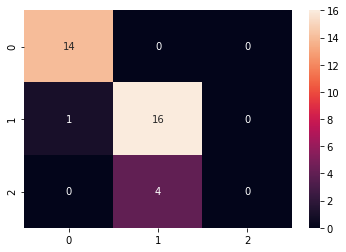

In [29]:
df_cm = pd.DataFrame(mat, range(3), range(3))

sns.heatmap(df_cm, annot=True) 
plt.show()

In [30]:
classification_rep = sklearn.metrics.classification_report(true,predicted,target_names=['negative', 'neutral', 'positive'])
print(classification_rep)

              precision    recall  f1-score   support

    negative       0.93      1.00      0.97        14
     neutral       0.80      0.94      0.86        17
    positive       0.00      0.00      0.00         4

    accuracy                           0.86        35
   macro avg       0.58      0.65      0.61        35
weighted avg       0.76      0.86      0.81        35



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
sklearn.metrics.accuracy_score(true,predicted)

0.8571428571428571

### BERT Model #2
https://simpletransformers.ai/docs/usage/

In [118]:
model_args = ClassificationArgs()
model_args.train_batch_size = 2 #evalution batch size
model_args.gradient_accumulation_steps = 8 #The number of training steps to execute before
                                          #performing a optimizer.step(). Effectively increases 
                                          #the training batch size while sacrificing training time 
                                          #to lower memory consumption.
model_args.learning_rate = 3e-5 #learning rate for training
model_args.num_train_epochs = 1 #number of epochs the model will be trained for
model_args.overwrite_output_dir = True #if True, the trained model will be saved to the output_dir
                                        #and will overwrite existing saed models in the same directory
model_args.max_seq_length = 512 #max sequence length the model will support

In [119]:
BERT_model_2 = ClassificationModel('bert', 'bert-base-uncased', num_labels=3, args=model_args,use_cuda=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [120]:
BERT_model_2.train_model(train_df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:377: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(8, 0.9059443371370435)

In [121]:
pred_bert, out_bert = BERT_model_2.predict(eval_df['text'].values)

acc_bert = accuracy_score(eval_df['label'].to_numpy(), pred_bert)
f1_bert = f1_score(eval_df['label'].to_numpy(), pred_bert, average='micro')

print("Accuracy score -->", acc_bert)
print("F1 score -->", f1_bert)


Accuracy score --> 0.8285714285714286
F1 score --> 0.8285714285714286


In [122]:
result, model_outputs, wrong_predictions = BERT_model_2.eval_model(eval_df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:896: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


In [123]:
print(result)
model_outputs

{'mcc': 0.7512275248938702, 'eval_loss': 0.7168849766254425}


array([[-0.11745656,  0.42185858, -0.9701106 ],
       [-0.12964346,  0.43755227, -0.95566213],
       [-0.12511346,  0.40915883, -0.96893489],
       [-0.066502  ,  0.48561531, -0.93668699],
       [ 1.08519101, -0.06421115, -0.82330406],
       [ 1.04764056, -0.02043952, -0.87026405],
       [ 1.04778671, -0.05678937, -0.78641629],
       [ 1.08954489, -0.14374007, -0.74732119],
       [-0.08802464,  0.39966279, -0.94366819],
       [ 1.05833852, -0.07568102, -0.82738316],
       [ 1.06842172,  0.06350344, -0.82822323],
       [ 1.07277966, -0.11350952, -0.7710253 ],
       [-0.12231559,  0.42923033, -0.94565946],
       [ 1.01368654, -0.06453186, -0.85806847],
       [-0.05973402,  0.44733372, -0.93739057],
       [-0.09395054,  0.43194973, -0.94269699],
       [ 1.0573132 , -0.06358285, -0.83464223],
       [-0.10730971,  0.50090706, -0.91838455],
       [-0.09852747,  0.40158823, -0.94387913],
       [ 1.06800759, -0.10072429, -0.80111241],
       [-0.0913043 ,  0.46304739, -0.911

In [124]:
true = eval_df['label'].tolist()
predicted = []
for arr in model_outputs:
    predicted.append(np.argmax(arr))

In [106]:
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

cm2 = confusion_matrix(true , predicted)
cm2

array([[16,  0,  0],
       [ 0, 13,  0],
       [ 0,  6,  0]])

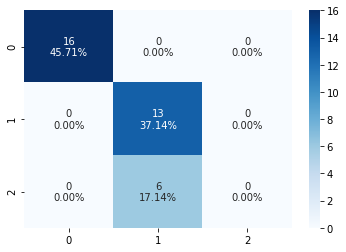

In [125]:
# cm = confusion_matrix(pred_bert, test_x_y['labels'].to_numpy())

#group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm2.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm2.flatten()/np.sum(cm2)]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)
sns.heatmap(cm2, annot=labels, fmt="", cmap='Blues')
plt.show()

In [126]:
classification_rep = sklearn.metrics.classification_report(true,predicted,target_names=['negative', 'neutral', 'positive'])
print(classification_rep)

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00        16
     neutral       0.68      1.00      0.81        13
    positive       0.00      0.00      0.00         6

    accuracy                           0.83        35
   macro avg       0.56      0.67      0.60        35
weighted avg       0.71      0.83      0.76        35



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [127]:
sklearn.metrics.accuracy_score(true,predicted)

0.8285714285714286